In [1]:
using Plots
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random 
using ArraysOfArrays
using ValueShapes
using Measurements
using BAT 

# 1. Densities

Activate the desired distribution:  

## 1.1 Multivariate Normal Distribution:

In [ ]:
# no correltions: 

n_dims = 5 
σ = 1
distribution = MvNormal(n_dims,σ)

prior = NamedTupleDist(
    x = repeat([-5.0 .. 5.0], n_dims),
);

In [ ]:
Σ = [3.426818298733095 12.378238116671048 -9.632531611142456; 
    12.378238116671048 69.83909693165143 -43.478993858310886; 
    -9.632531611142456 -43.478993858310886 60.0626256206892]

μ = [8.959570984309234, -9.021529871694005, -5.007789383392622]

n_dims = 3 

distribution = MvNormal(μ, Σ)

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

## 1.2 Gaussian Mixture Model (3D): 

In [ ]:
n_dims = 3 

σ_1 = [3.426818298733095 12.378238116671048 -9.632531611142454; 3.426818298733095 4.916266580684483 -5.029942800849483; 3.426818298733095 -6.737309268887753 5.4343957706004415; 3.426818298733095 -3.9729587574454333 3.379361860370276]
σ_2 = [12.378238116671048 69.83909693165143 -43.478993858310886; 4.916266580684482 69.83909693165143 -64.18784570966332; -6.737309268887753 69.83909693165143 32.734776615550174; -3.972958757445433 69.83909693165143 53.74871853095418]
σ_3 = [-9.632531611142456 -43.478993858310886 60.0626256206892; -5.029942800849484 -64.18784570966332 60.0626256206892; 5.4343957706004415 32.734776615550174 60.0626256206892; 3.3793618603702757 53.74871853095418 60.0626256206892]
σ = cat(σ_1,σ_2,σ_3, dims=3)

μ = [8.959570984309234 -9.021529871694005 -5.007789383392622; -1.446445514344754 -7.8327010768703875 -3.2653263028963986; -6.40954093270941 0.25815094665222027 5.830143596540282; 5.076504517881521 -0.8952973253675331 9.16356325348496]

distribution = MixtureModel(MvNormal[MvNormal(μ[i,:], Matrix(Hermitian(σ[i,:,:])) ) for i in 1:4]);

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

## 1.3 Funnel Distribution: 

In [2]:
n_dims = 4

distribution = BAT.FunnelDistribution(n=n_dims)

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

## 1.4 Caushy Distribution: 

In [ ]:
n_dims = 2

distribution = BAT.MultimodalCauchy(n=n_dims);

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

## 1.5 Gaussian Shell: 

In [ ]:
n_dims = 2

distribution = BAT.GaussianShell(n=n_dims);

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

# 2. Sampling

In [3]:
log_likelihood = let dist = distribution
    params -> begin
        LogDVal(logpdf(dist, params.x))
    end
end

posterior = PosteriorDensity(log_likelihood, prior);

In [4]:
nsamples = 5*10^5

500000

In [8]:
# Generate MCMC Samples: 

samples = bat_sample(
    posterior, 
    nsamples, MCMCSampling(sampler = MetropolisHastings(), nchains = 4)
).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/s

In [10]:
# Generate IID sampls (no prior included, only target distribution)

samples = bat_sample(distribution, nsamples, IIDSampling()).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


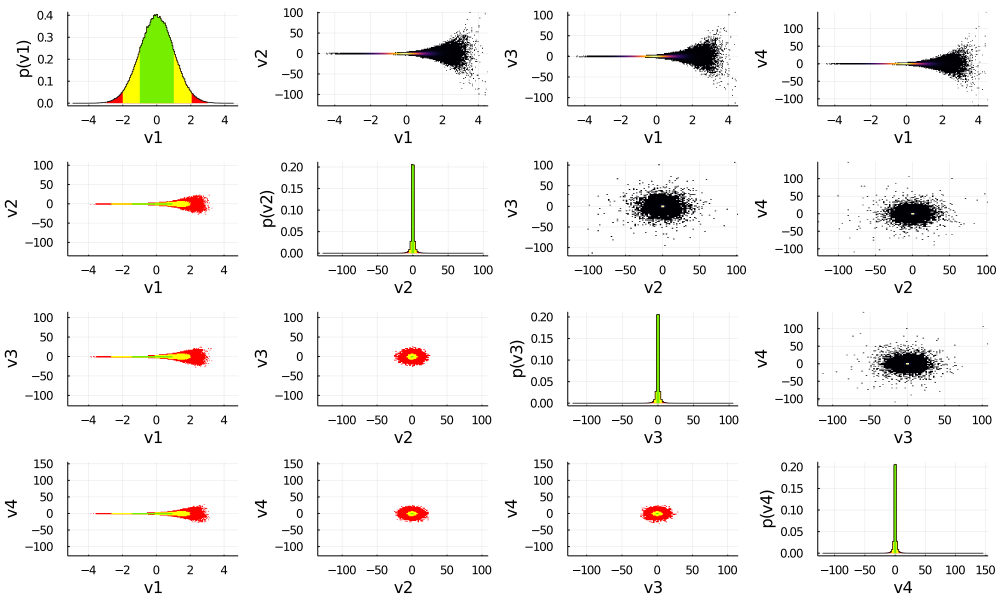

In [11]:
plot(samples)

# 3. Integration

In [7]:
# Convert MCMC samples in a flat vector: 

samples_flat = collect(flatview(unshaped.(samples.v)))
weights = samples.weight;

***

### Algorithm Overview: 

1. Get samples (MCMC samples with frequency weights, resampled samples with unitary weights)
2. Whiten samples
3. Run k-means to cluster points (n clusters depends on problem dmension)
4. Initialize centers of hypervolumes at the center of each cluster 
5. The initial size of s hypervolume is a standard deviation of samples at each cluster.
6. Trim boundaries of clusters to adjust log. likelihood ratio.
7. Compute harmonic mean estimate (HME) for each hypervolume and combine the final estimator. 

### Integration volumes to be considered: 

1. Hyperspheres. 
2. Spherical shells. 